In [827]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
%matplotlib inlineJ

#pd.set_option('display.width', 20, 'display.max_colwidth', -1)
pd.set_option('display.max_colwidth', -1)

In [964]:
#print(plt.style.available)
#import matplotlib as mpl
#print(mpl.get_configdir())

In [867]:
df = pd.read_csv('all.csv')

df1 = df[df.EmailAddress.isnull()]

In [965]:
# Create dataframe for ytick labels mapping to be used in the bar charts later
def tickMap(my_map):
    tick_dic = {}
    for x in list(my_map):
        # Add wrap() to make ytick labels to wrap in the plot
        tick_dic[x] = '\n'.join(wrap(my_map[x].to_string(index=False).encode('utf-8'), 30))
    tickFrame = pd.DataFrame(tick_dic.items(),columns=['Name0', 'tickName'])
    tickFrame['Name'] = tickFrame.Name0+' avg'
    return tickFrame

In [1101]:
p = tickMap(df1.head(1).loc[:,'Product1':'Product7'])
r = tickMap(df1.head(1).loc[:,'Requirement1':'Requirement3'])
i = tickMap(df1.head(1).loc[:,'Implementation1':'Implementation4'])
ro = tickMap(df1.head(1).loc[:,'Rollout1':'Rollout3'])
t = tickMap(df1.head(1).loc[:,'TechSupport1':'TechSupport3'])

In [1086]:
# Set up all static variables
survey_items = ['Product1','Product2','Product3','Product4','Product5','Product6','Product7','Requirement1','Requirement2','Requirement3','Implementation1','Implementation2','Implementation3','Implementation4','Rollout1','Rollout2','Rollout3','TechSupport1','TechSupport2','TechSupport3']
weights = {'Not in a position to evaluate':0,'Did not meet expectations':1,'Partially met expectations':2,'Met expectations':3,'Exceeded expectations':4,'Far exceeded expectations':5}

regions = ['Region','US','EU','JP','CN']
clients = ['Company','Pfizer','Lilly','Merck Serono','Sunovion','MSD','AZ','BMS']
clientRegion = [['Company','Region'],['Pfizer','US'],['Pfizer','JP'],['Pfizer','CN'],['Sunovion','US'],['Lilly','JP'],['MSD','EU'],['Merck Serono','JP'],['AZ','JP'],['BMS','US']]

invite_count = 37

In [1102]:
def segmentation(seg1,value1):
    #df_seg = df[(df[seg1]==value1)|(df[seg2]==value2)|(df.EmailAddress.isnull())]
    if isinstance(value1, list):
        df_seg = df[(df[seg1[0]]==value1[0])&(df[seg1[1]]==value1[1])]
    else:
        df_seg = df[(df[seg1]==value1)]
    # Calculate question statistics for each survey columns in csv
    result_avg = {'seg':seg1,'value':value1}
    result_response = {'seg':seg1,'value':value1}
    for si in survey_items:
        col = df_seg[si].value_counts()
        base = col.sum()
        avg = 0
        for k in col.index.tolist():
            if k=='Not in a position to evaluate':
                base = base - col['Not in a position to evaluate']
        for k in col.index.tolist():
            avg = avg + weights[k]*(float(col[k])/float(base))
        #col['response rate'] = "{:.1%}".format(float(col.sum())/float(invite_count))
        new_key = si + ' avg'
        result_avg[new_key] = "%.1f" % avg
        #new_key = si + ' response rate'
        #result_response[new_key] = col['response rate']
    return result_avg#,result_response

In [1073]:
# To be used later to set survey items in order in the DataFrame
orders = {'Product':['Product1 avg', 'Product2 avg', 'Product3 avg', 'Product4 avg', 'Product5 avg', 'Product6 avg', 'Product7 avg'],
 'Requirement':['Requirement1 avg','Requirement2 avg','Requirement3 avg'],
 'Implementation':['Implementation1 avg','Implementation2 avg','Implementation3 avg','Implementation4 avg'],
 'Rollout':['Rollout1 avg','Rollout2 avg','Rollout3 avg'],
 'TechSupport':['TechSupport1 avg','TechSupport2 avg','TechSupport3 avg']}

p_list = ['Product1 avg', 'Product2 avg', 'Product3 avg', 'Product4 avg', 'Product5 avg', 'Product6 avg', 'Product7 avg']
r_list = ['Requirement1 avg','Requirement2 avg','Requirement3 avg']
i_list = ['Implementation1 avg','Implementation2 avg','Implementation3 avg','Implementation4 avg']
ro_list = ['Rollout1 avg','Rollout2 avg','Rollout3 avg']
t_list = ['TechSupport1 avg','TechSupport2 avg','TechSupport3 avg']

In [1059]:
def packResult(my_dict,my_type,loopLoc):
    if isinstance(loopLoc, list):
        lp = '_'.join(loopLoc)
    else:
        lp = loopLoc
    d = {k:float(v) for k,v in my_dict.iteritems() if k[:len(my_type)]== my_type}
    d_df = pd.DataFrame(d.items(),columns=['Name', 'Avg_'+lp])
    o = orders[my_type]
    mapping = {p: i for i, p in enumerate(o)}
    key = d_df['Name'].map(mapping)
    d_df = d_df.iloc[key.argsort()]
    return d_df

In [1104]:
def compare(category):
    product = pd.DataFrame(p_list, columns = ['Name'])
    requirement = pd.DataFrame(r_list, columns = ['Name'])
    implementation = pd.DataFrame(i_list, columns = ['Name'])
    rollout = pd.DataFrame(ro_list, columns = ['Name'])
    techSupport = pd.DataFrame(t_list, columns = ['Name'])

    for c in category[1:]:
        #d1,d2 = segmentation(category[0],c)
        d1 = segmentation(category[0],c)
        product = pd.merge(product,packResult(d1,'Product',c),on='Name')
        requirement = pd.merge(requirement,packResult(d1,'Requirement',c),on='Name')
        implementation = pd.merge(implementation,packResult(d1,'Implementation',c),on='Name')
        rollout = pd.merge(rollout,packResult(d1,'Rollout',c),on='Name')
        techSupport = pd.merge(techSupport,packResult(d1,'TechSupport',c),on='Name')
    product = pd.merge(p,product,on='Name')
    requirement = pd.merge(r,requirement,on='Name')
    implementation = pd.merge(i,implementation,on='Name')
    rollout = pd.merge(ro,rollout,on='Name')
    techSupport = pd.merge(t,techSupport,on='Name')

    # Print bar chart for Product
    ax_prod = product.plot(kind='barh', xlim=(0, 5),figsize=(20,20), fontsize=20)
    ax_prod.set_yticklabels(product.tickName)
    ax_prod.set_title('Product',fontsize= 30)

    # Print bar chart for Requirement
    ax_req = requirement.plot(kind='barh', xlim=(0, 5),figsize=(20,9), fontsize=20)
    ax_req.set_yticklabels(requirement.tickName)
    ax_req.set_title('Requirement',fontsize= 30)

    # Print bar chart for Implementation
    ax_imp = implementation.plot(kind='barh', xlim=(0, 5),figsize=(20,12), fontsize=20)
    ax_imp.set_yticklabels(implementation.tickName)
    ax_imp.set_title('Implementation',fontsize= 30)

    # Print bar chart for Rollout
    ax_rol = rollout.plot(kind='barh', xlim=(0, 5),figsize=(20,9), fontsize=20)
    ax_rol.set_yticklabels(rollout.tickName)
    ax_rol.set_title('Rollout',fontsize= 30)

    # Print bar chart for TechSupport
    ax_tes = techSupport.plot(kind='barh', xlim=(0, 5),figsize=(18,9), fontsize=20)
    ax_tes.set_yticklabels(techSupport.tickName)
    ax_tes.set_title('TechSupport',fontsize= 30)
    plt.show()

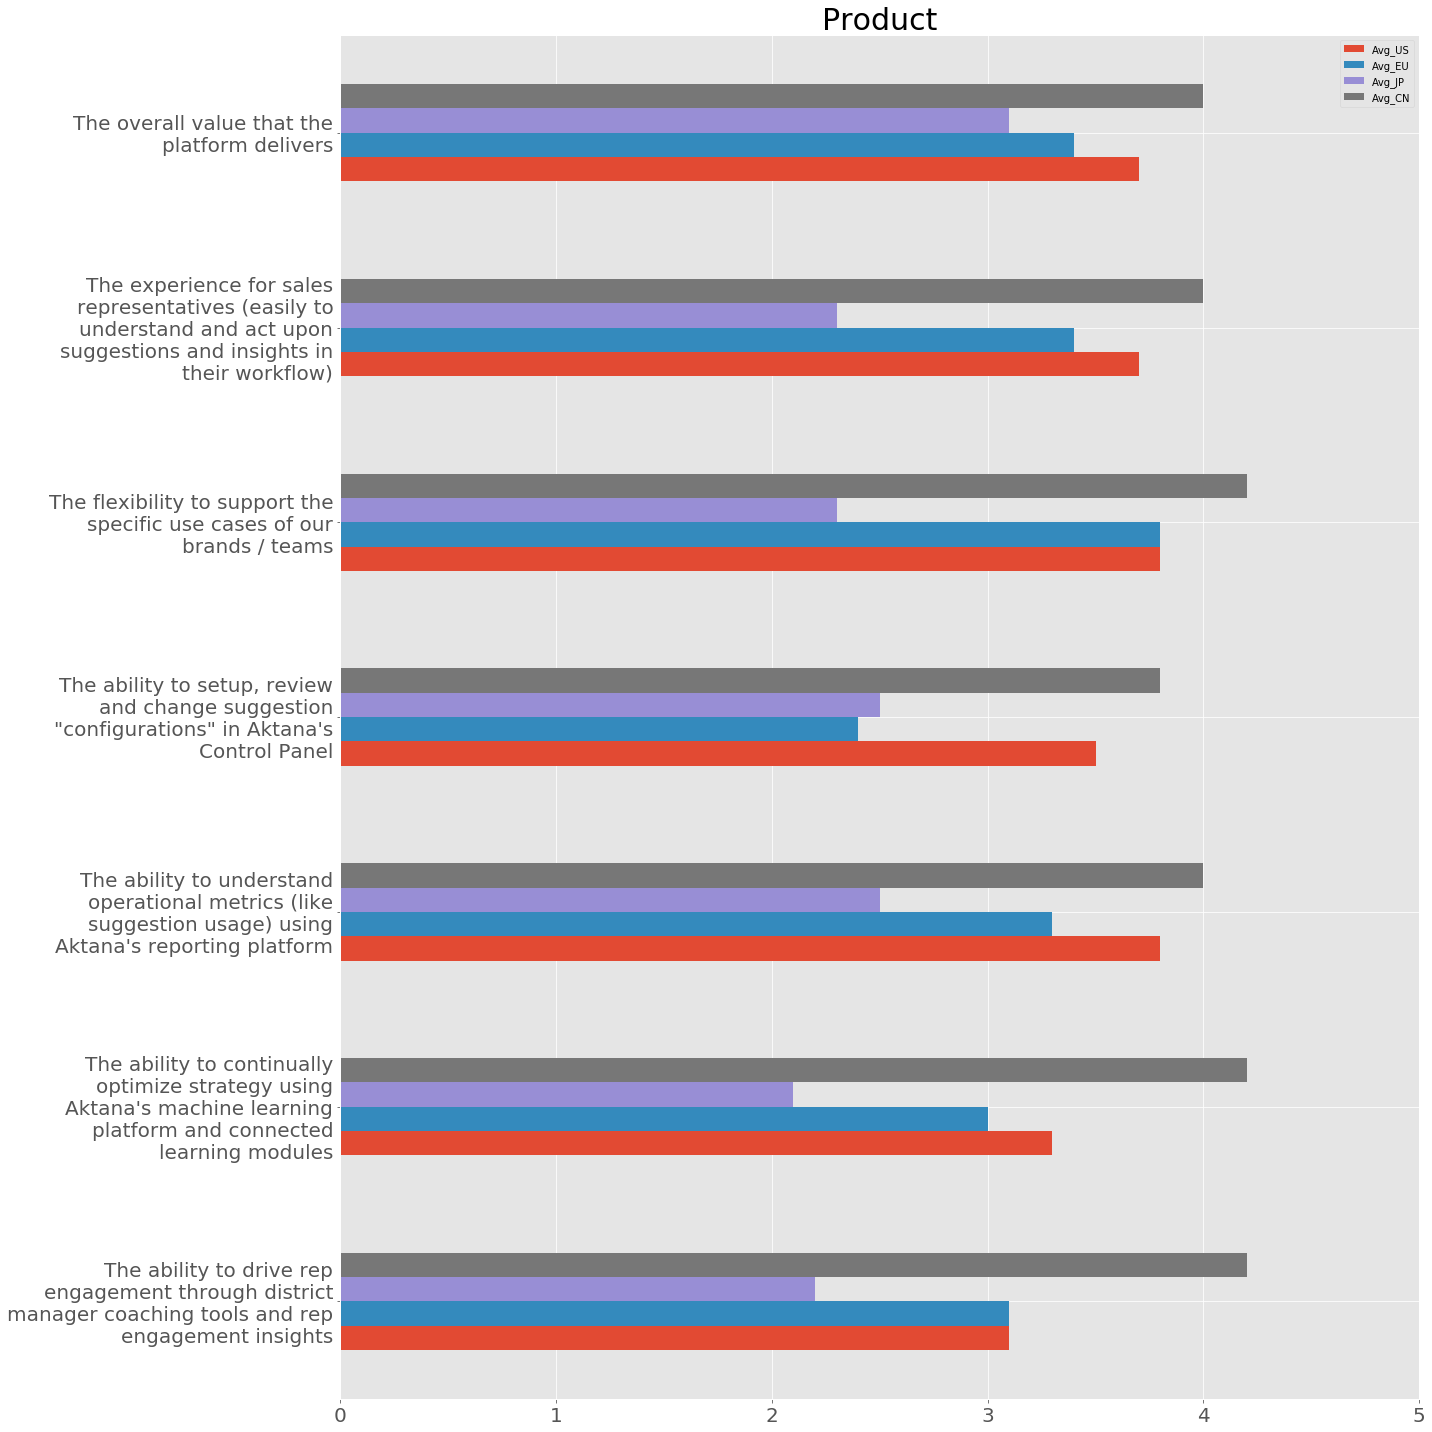

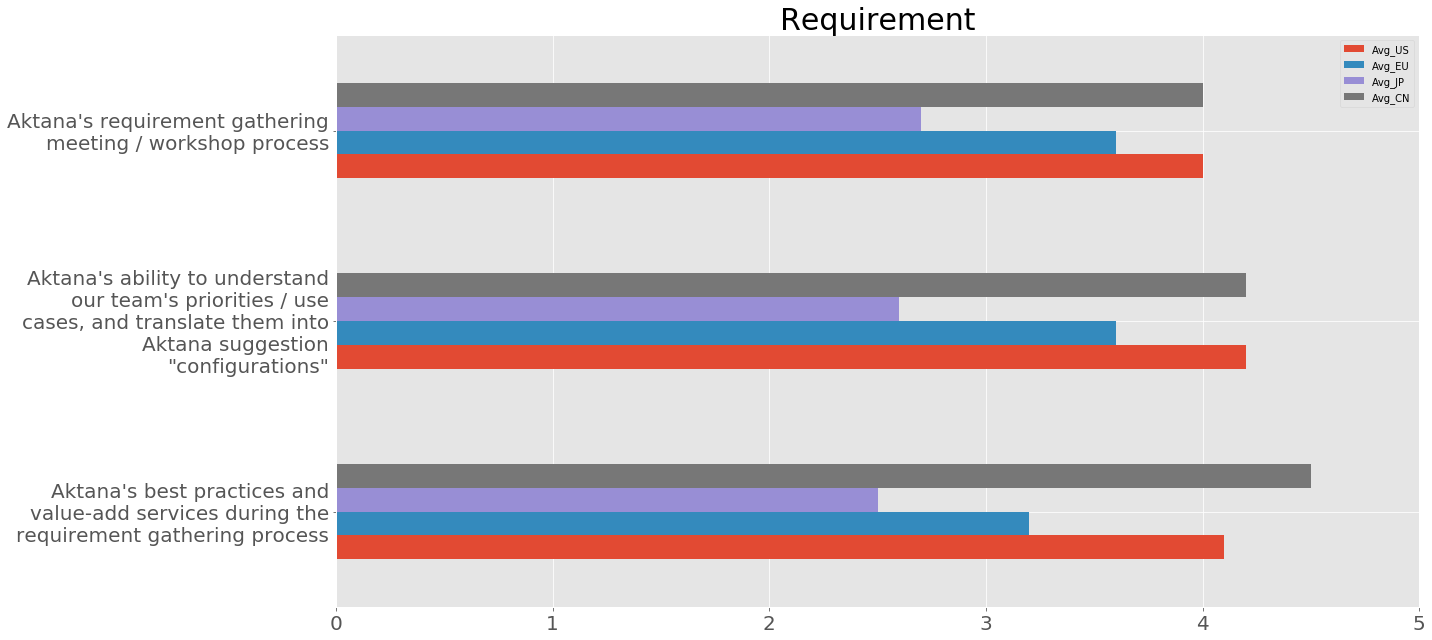

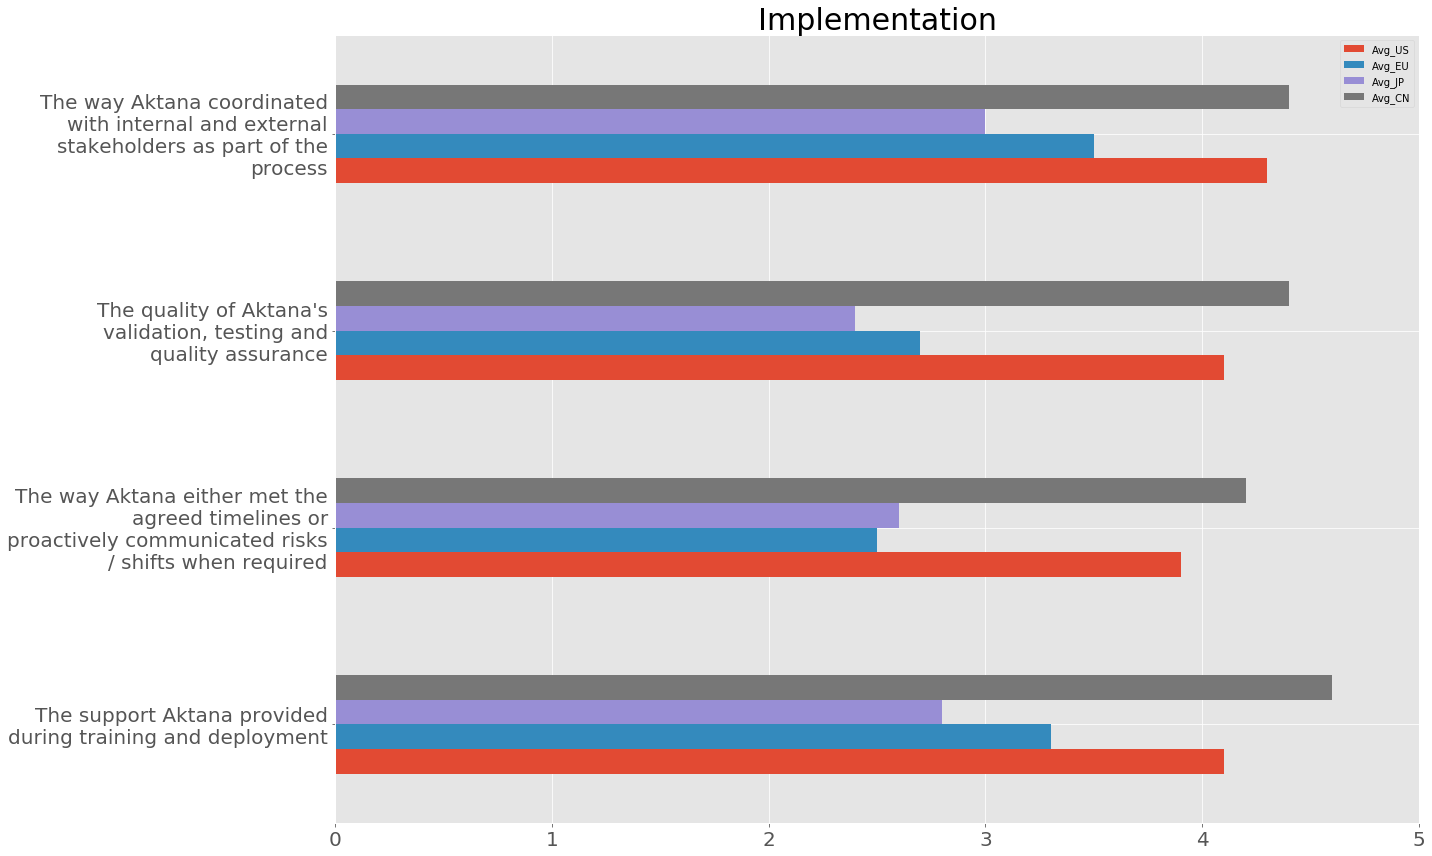

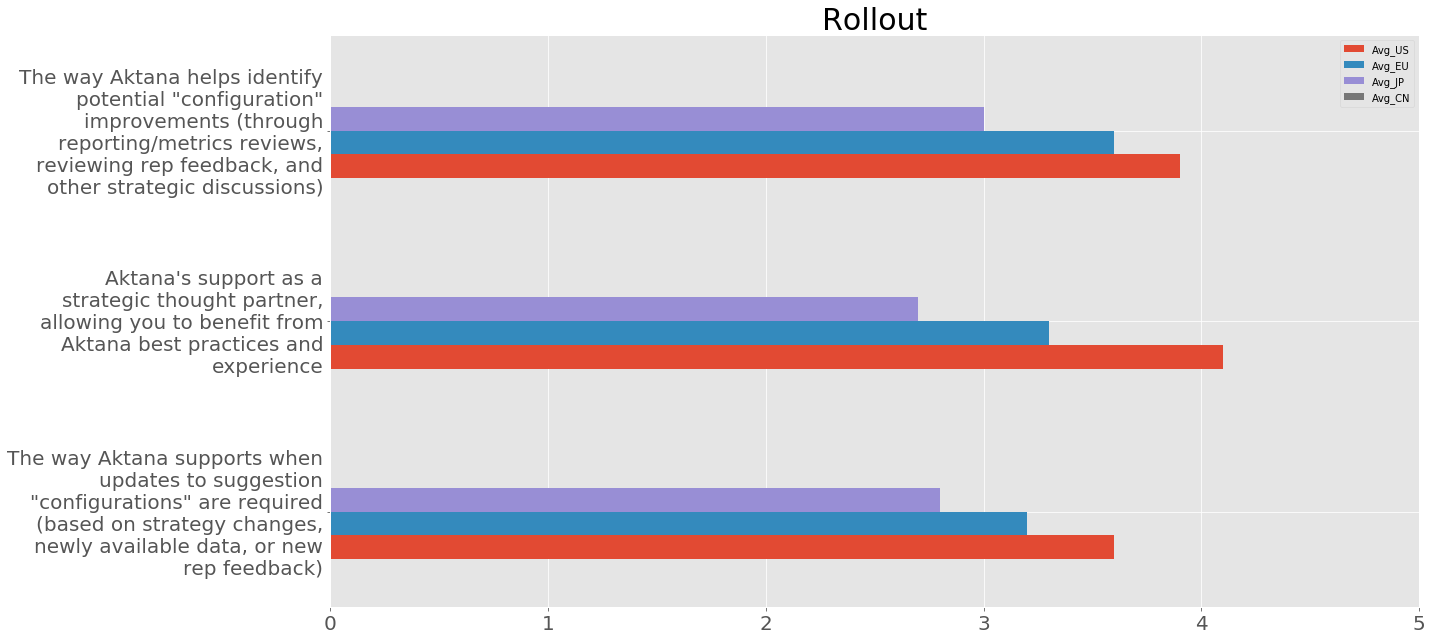

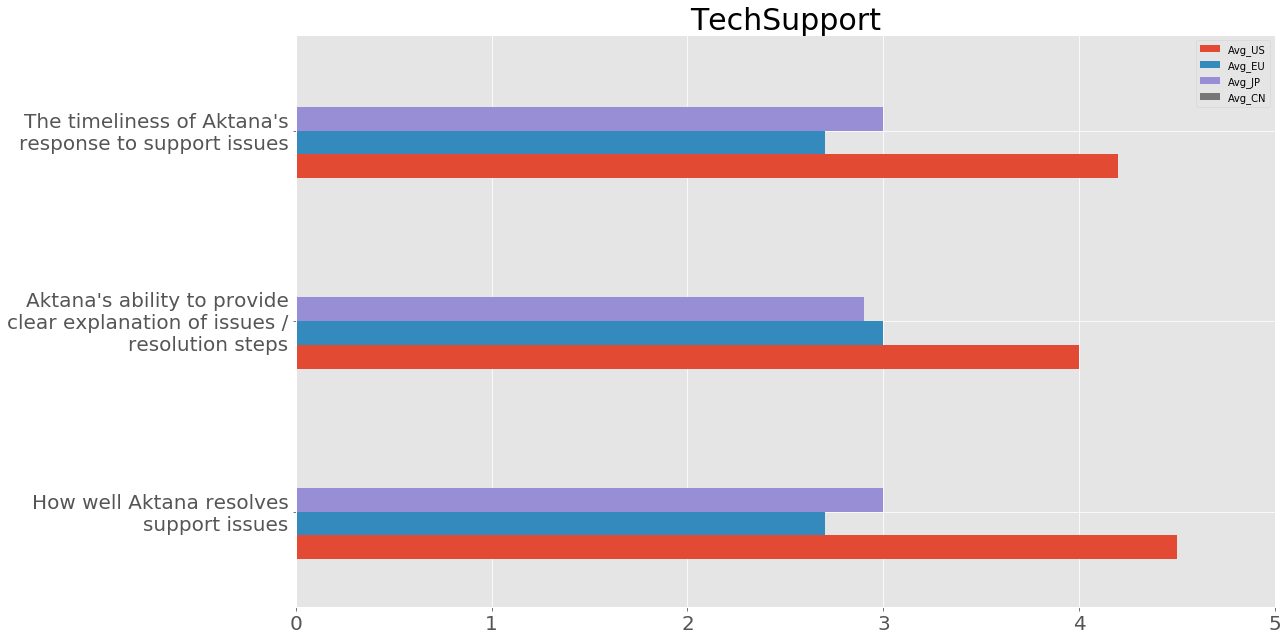

In [1105]:
compare(regions)

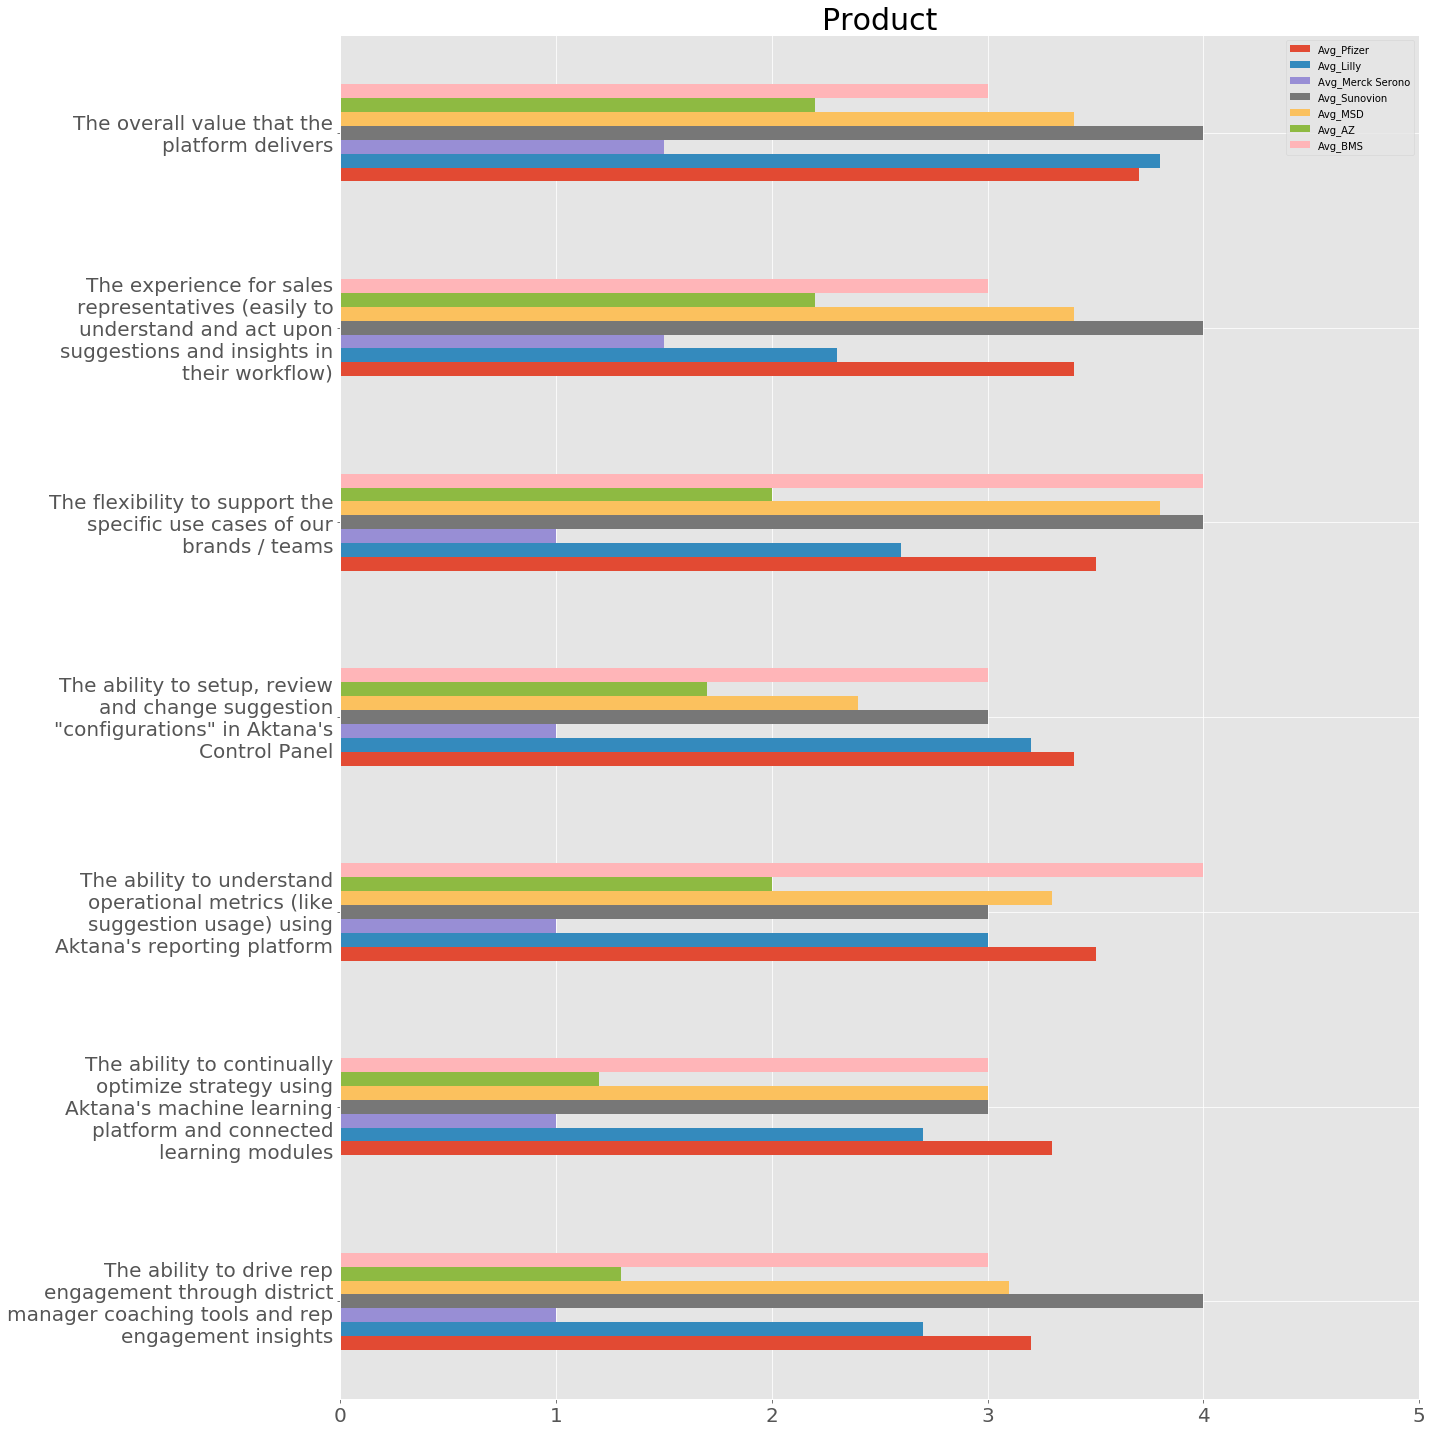

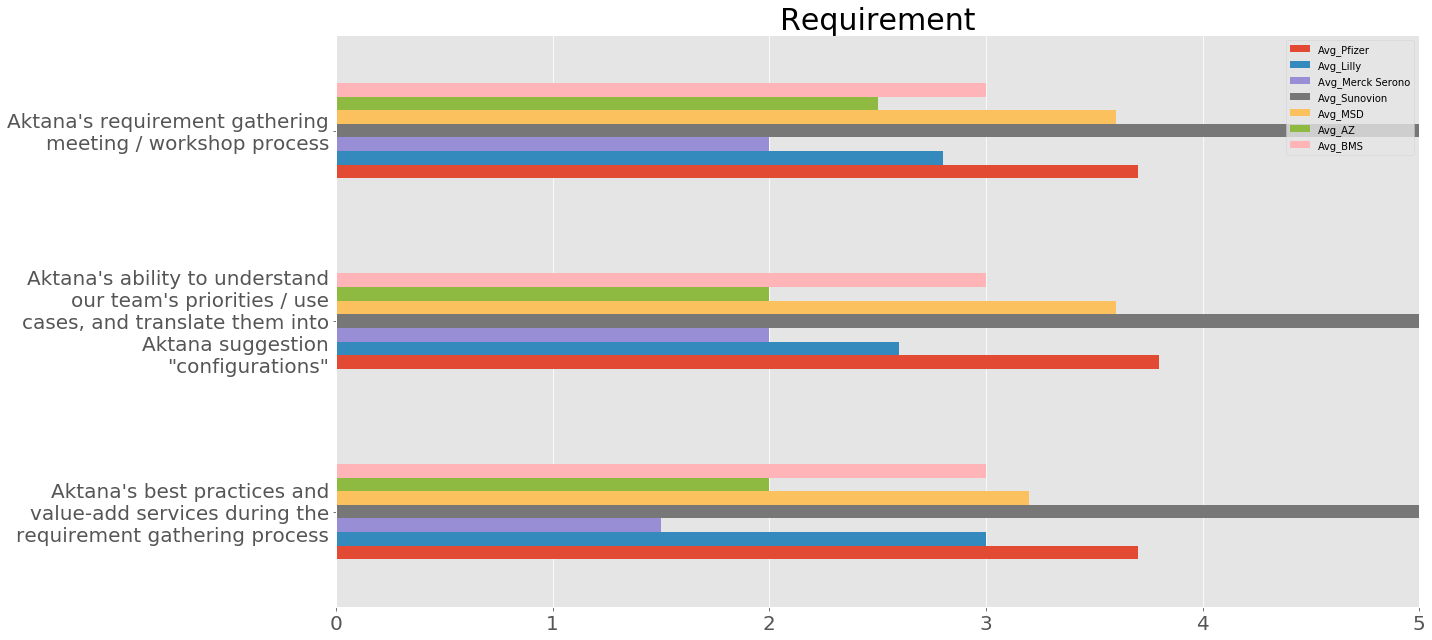

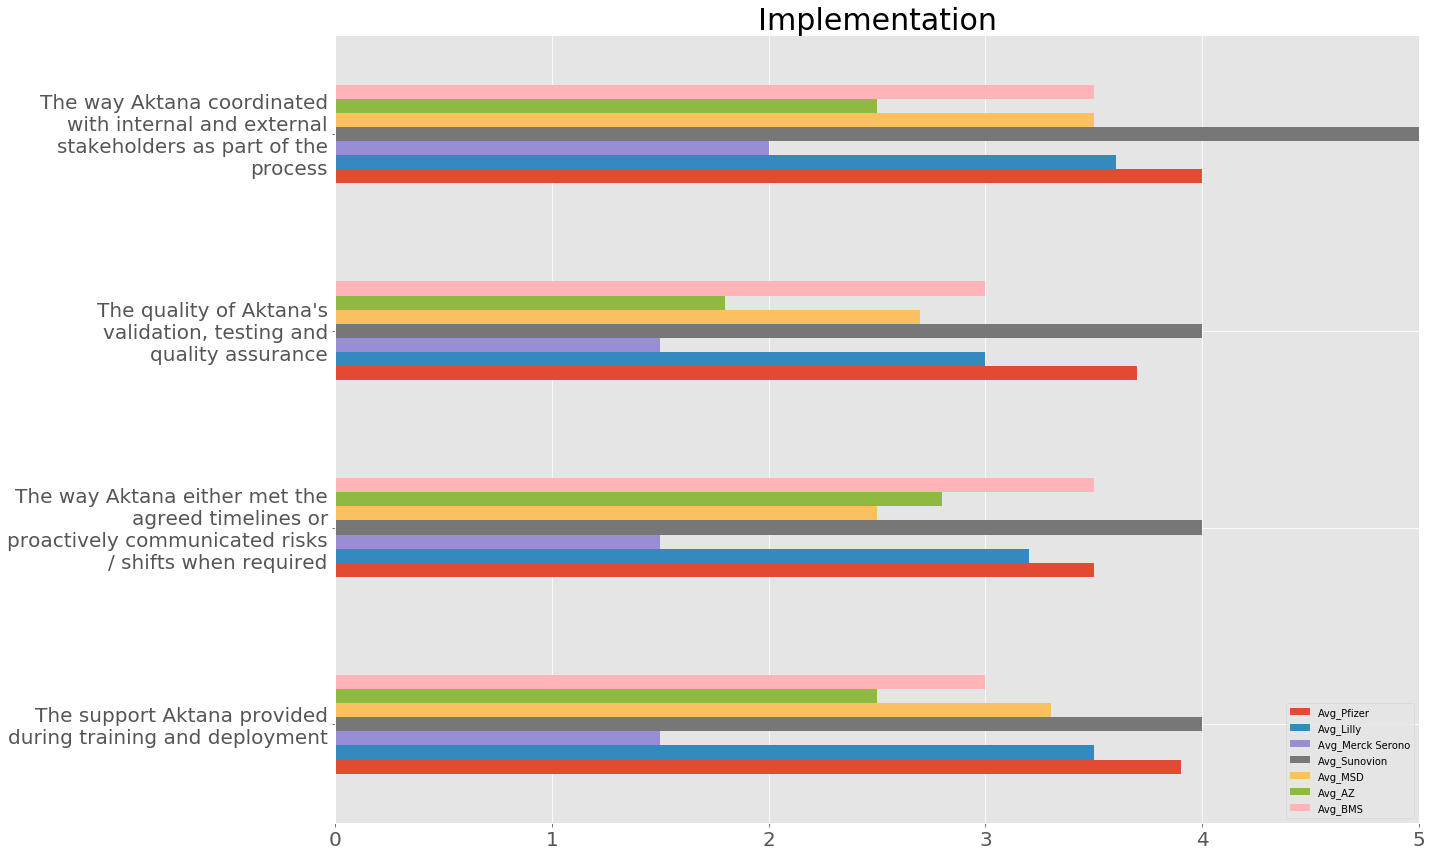

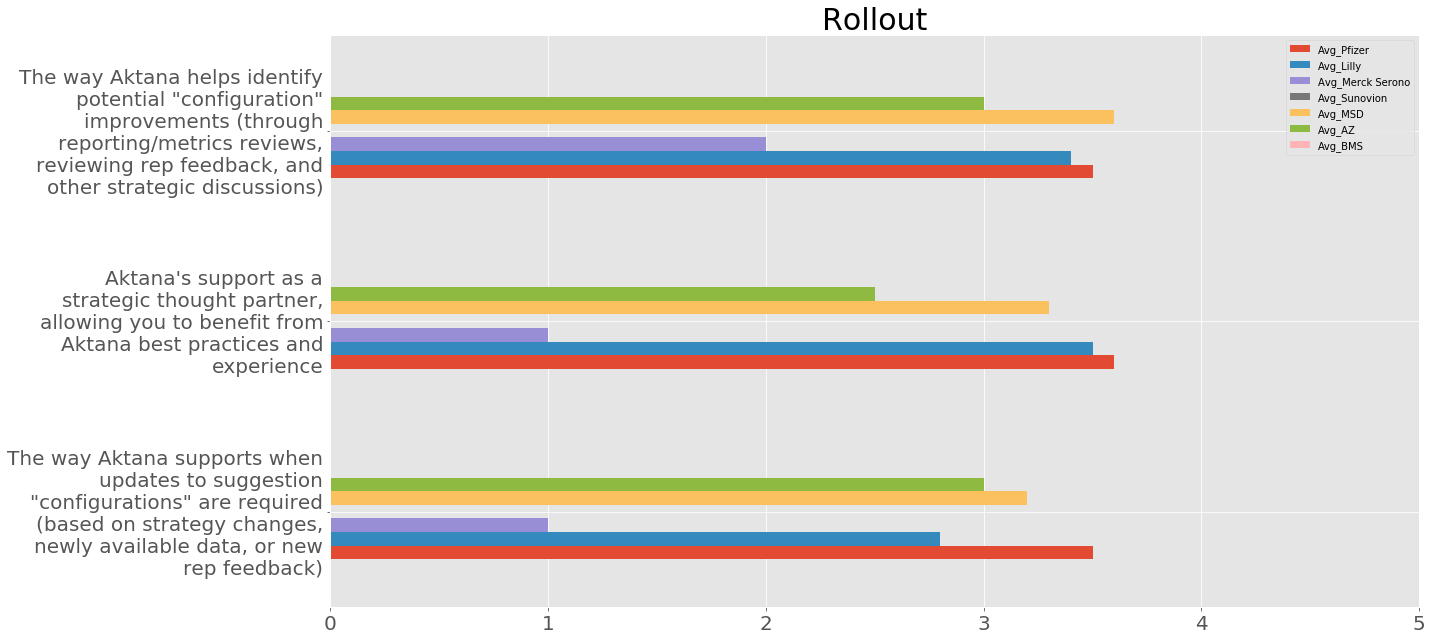

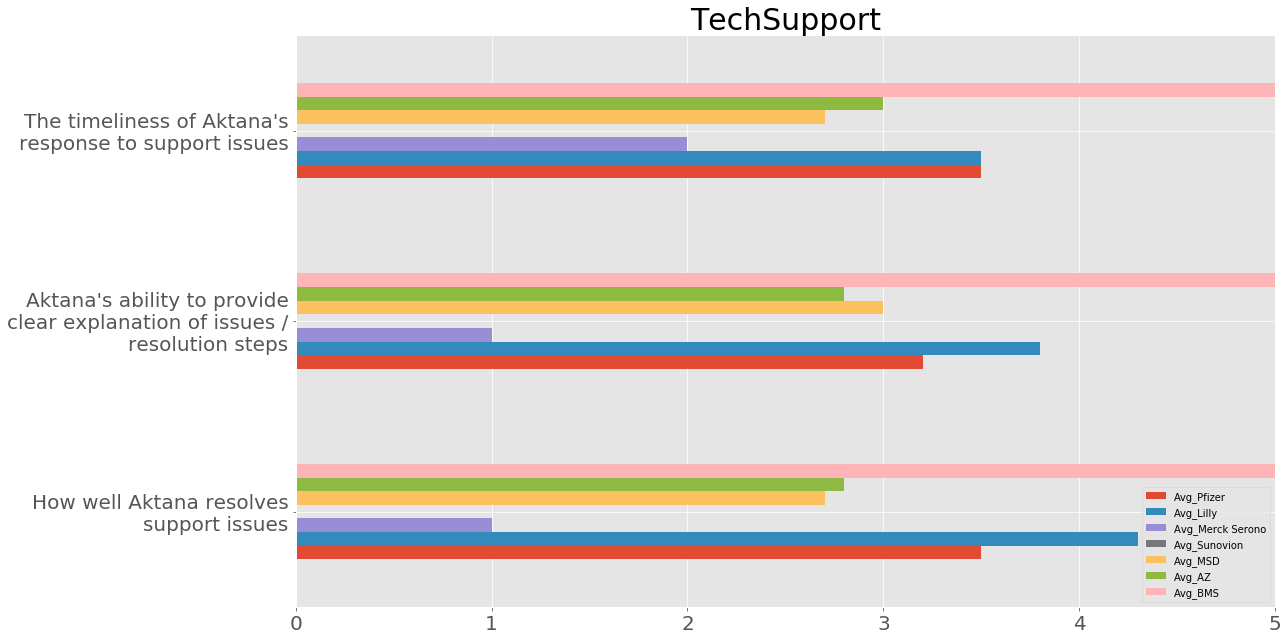

In [1106]:
compare(clients)

In [1100]:
#compare(clientRegion)